In [235]:
using DataFrames, CSV
using Convex, ECOS  # Convex modeling and solver
using Distributions, Random  # Seeds and sampling
using LightGraphs  # Generating nice random graphs
using Plots, Colors, GraphRecipes  # For plottig

using Revise
using CarbonNetworks

# Load data

## Load network

In [484]:
A, gmax, pmax, f, G, nodes = parse_network_data()
n = length(gmax)
m = length(pmax)

@show n, m

inds = findall(v -> v[3] in ["WAT"], nodes)
gmax[inds] .*= 0.5;  # usually less hydro is available

(n, m) = (684, 775)


## Load case

In [485]:
case = DataFrame(CSV.File(CarbonNetworks.get_data_path("case_4.csv")))
rename!(case, "Column1" => "ba")
case = coalesce.(case, 0.0)

bas = case[:, "ba"]
demands = case[:, "net_demand"]

d = zeros(n)
for (dem, ba) in zip(demands, bas)
    ind_d = findfirst(x -> x[2:3] == (ba, "DEMAND"), nodes)
    d[ind_d] = dem
end

@show sum(gmax)
@show sum(d);

sum(gmax) = 850364.0192495093
sum(d) = 283058.8631506813


# Let's solve the carbon minimization problem

In [486]:
primary_nodes = [ind for (ind, iso, res) in nodes if res == "DEMAND"]
primary_edges = [ind for (ind, e) in enumerate(edges(G)) 
        if e.src in primary_nodes && e.dst in primary_nodes];

In [487]:
g = Variable(n)
r = Variable(n)  # curtailed demand
p = Variable(m)

# Make 'infinite' constraint large but not tight
p̅ = copy(pmax)
p̅[p̅ .== Inf] .= 1.5 * maximum(gmax)

# Make cost of curtailed demand large
α = 2*maximum(f)

problem = minimize(f'g + α*sum(r))
add_constraints!(problem, d - g - r == A*p)
add_constraints!(problem, abs(p) <= p̅)
add_constraints!(problem, [0 <= g])
add_constraints!(problem, [g <= gmax])
add_constraints!(problem, r >= 0)

solve!(problem, () -> ECOS.Optimizer(verbose=false))

g = evaluate(g)
p = evaluate(p)
r = evaluate(r)

println("Percent demand curtailed: $(sum(r) / sum(d))")
println("Percent of power exchanged: $(sum(abs.(p[primary_edges])) / sum(d))")

Percent demand curtailed: -7.404321939617797e-13
Percent of power exchanged: 0.055684839140833296


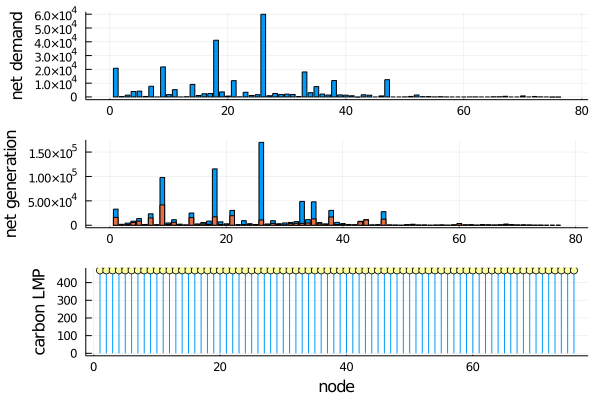

In [488]:
ν = problem.constraints[1].dual[:, 1]
ν = -ν[primary_nodes]
d_primary = d[primary_nodes]

push!(primary_nodes, lastindex(g))
g_primary = [sum(g[[tup[2] == nodes[i][2] for tup in nodes]]) for i in primary_nodes]
gmax_primary = [sum(gmax[[v[2] == nodes[i][2] for v in nodes]]) for i in primary_nodes]
pop!(primary_nodes)

gradient = cgrad(:inferno)
lmp_colors = [get(gradient, νi/maximum(ν)) for νi in ν]

plt1 = bar(d_primary, label=nothing, ylabel="net demand")
plt2 = bar(gmax_primary, label=nothing, ylabel="net generation")
bar!(plt2, g_primary, label=nothing)

plt3 = sticks(ν, label=nothing, ylabel="carbon LMP", xlabel="node")
scatter!(plt3, ν, c=lmp_colors, label=nothing)

plot(plt1, plt2, plt3, layout=(3, 1))

## Aggregrate generation by resource

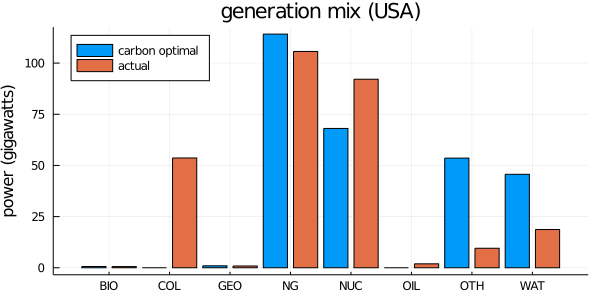

In [489]:
resources = unique([v[3] for v in nodes])
deleteat!(resources, 1)  # Remove demand

ba_id(ba) = findfirst(==(ba), bas)
res_id(res) = findfirst(==(res), resources)

gen_matrix = zeros(length(bas), length(resources))
gen_max_matrix = zeros(length(bas), length(resources))
for (id, ba, res) in nodes
    res == "DEMAND" && continue

    #@show g[id]
    #@show ba_id(ba), res_id(res)
    gen_matrix[ba_id(ba), res_id(res)] = g[id]
    gen_max_matrix[ba_id(ba), res_id(res)] = gmax[id]
end

max_dispatch = sum(gen_max_matrix, dims=1)[1, :]
carb_min_dispatch = sum(gen_matrix, dims=1)[1, :] / 1e3
actual_dispatch = sum(Matrix(case[:, resources]), dims=1)[1, :] / 1e3

theme(:default)
x = 1:length(carb_min_dispatch)
plt = plot(size=(600, 300))
bar!(x .- 0.25, carb_min_dispatch, bar_width=0.4, label="carbon optimal")
bar!(x .+ 0.25, actual_dispatch, bar_width=0.4, label="actual")
plot!(xticks=(1:length(carb_min_dispatch), resources), ylabel="power (gigawatts)")
plot!(legend=:topleft, title="generation mix (USA)")
savefig(plt, "./gen_mix.png")
display(plt)

In [456]:
_, _, df_res = open_datasets()

f[6]

16.0